Imports

In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Load and check dataset

In [4]:
#Load dataset
df = pd.read_csv("/content/ACME-HappinessSurvey2020.csv")

print(df.to_string)

<bound method DataFrame.to_string of      Y  X1  X2  X3  X4  X5  X6
0    0   3   3   3   4   2   4
1    0   3   2   3   5   4   3
2    1   5   3   3   3   3   5
3    0   5   4   3   3   3   5
4    0   5   4   3   3   3   5
..  ..  ..  ..  ..  ..  ..  ..
121  1   5   2   3   4   4   3
122  1   5   2   3   4   2   5
123  1   5   3   3   4   4   5
124  0   4   3   3   4   4   5
125  0   5   3   2   5   5   5

[126 rows x 7 columns]>


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [11]:
df.nunique()

,0
Y,2
X1,4
X2,5
X3,5
X4,5
X5,5
X6,5


In [12]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [13]:
df.isnull().sum()

,0
Y,0
X1,0
X2,0
X3,0
X4,0
X5,0
X6,0


In [14]:
df['Y'].value_counts(normalize=True)

,proportion
Y,
1,0.547619
0,0.452381


In [20]:
df.groupby('Y').mean()

,X1,X2,X3,X4,X5,X6
Y,,,,,,
0,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
1,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812


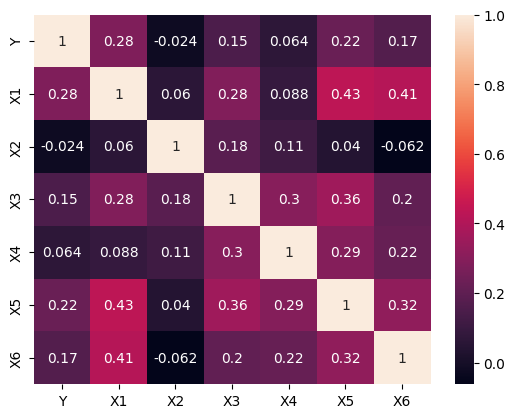

In [19]:
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

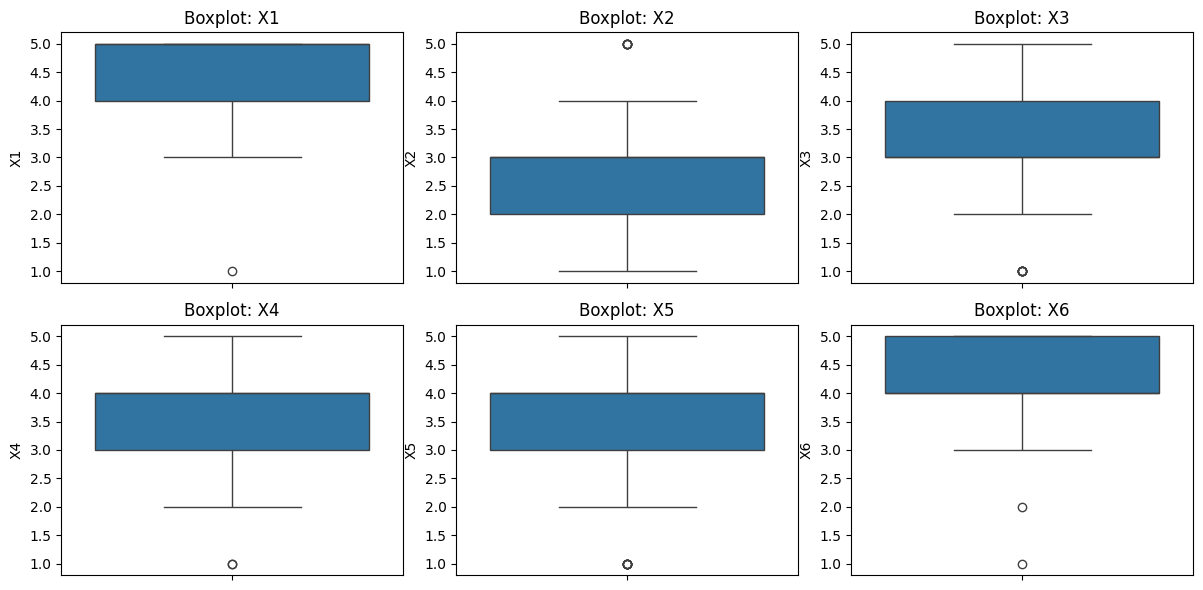

Number of outliers (Z-score > 3):
4
Number of outliers (IQR):
X1    1
X2    6
X3    7
X4    2
X5    7
X6    2
dtype: int64


In [25]:
X = df.drop(columns=['Y'])  # Y is target
y = df['Y']

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=X[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# 1B: Z-score method
z_scores = np.abs(stats.zscore(X))
outlier_mask_z = (z_scores > 3)
print("Number of outliers (Z-score > 3):")
print(outlier_mask_z.sum())

# 1C: IQR method
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outlier_mask_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR)))
print("Number of outliers (IQR):")
print(outlier_mask_iqr.sum())

Feature Preprocessing

In [3]:
#Features and labels
X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].values
y = df['Y'].values.reshape(-1, 1)

#Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

info = mutual_info_classif(X_train, y_train.ravel())
print("Feature Importance:", info)


Feature Importance: [0.04440946 0.         0.         0.00388998 0.04542586 0.00792247]


In [48]:
columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
info = np.array([0.04440946, 0., 0., 0.00388998, 0.04542586, 0.00792247])

informative_idx = np.where(info > 0.01)[0]
informative_features = [columns[i] for i in informative_idx]
print("Using features:", informative_features)

X = df[informative_features].values
y = df['Y'].values.ravel()

#Train-test split
from sklearn.model_selection import train_test_split
X_t, X_v, y_t, y_v = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Using features: ['X1', 'X5']


Model Implementation

In [7]:
#Binary classifier model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(

            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Training and Evaluation

In [37]:
#Model Checkpointing
best_val_acc = 0.0
best_model_path = "best_model.pth"

#Load model
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#model.load_state_dict(torch.load("/content/best_model_HC_0.7308.pth"))

for epoch in range(30):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_preds_label = (val_preds > 0.5).float()
        acc = accuracy_score(y_val_tensor, val_preds_label)

    #Saving best model
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch+1}/30 - Loss: {loss.item():.4f}, Val Accuracy: {acc:.4f} (Best: {best_val_acc:.4f})")

#Loading best model
model.load_state_dict(torch.load(best_model_path))
print(f"\nBest model restored with validation accuracy: {best_val_acc:.4f}")

Epoch 1/30 - Loss: 0.6856, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 2/30 - Loss: 0.7842, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 3/30 - Loss: 0.6543, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 4/30 - Loss: 0.6856, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 5/30 - Loss: 0.6173, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 6/30 - Loss: 0.5579, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 7/30 - Loss: 0.6244, Val Accuracy: 0.4615 (Best: 0.4615)
Epoch 8/30 - Loss: 0.7519, Val Accuracy: 0.6154 (Best: 0.6154)
Epoch 9/30 - Loss: 0.8324, Val Accuracy: 0.6923 (Best: 0.6923)
Epoch 10/30 - Loss: 0.7665, Val Accuracy: 0.6538 (Best: 0.6923)
Epoch 11/30 - Loss: 0.7043, Val Accuracy: 0.5769 (Best: 0.6923)
Epoch 12/30 - Loss: 0.6873, Val Accuracy: 0.6538 (Best: 0.6923)
Epoch 13/30 - Loss: 0.7017, Val Accuracy: 0.6538 (Best: 0.6923)
Epoch 14/30 - Loss: 0.6838, Val Accuracy: 0.6538 (Best: 0.6923)
Epoch 15/30 - Loss: 0.6904, Val Accuracy: 0.6154 (Best: 0.6923)
Epoch 16/30 - Loss: 0.6574, Val Accuracy: 0.6538 

Logistic Regression Implementation

In [9]:
#Without feature engineering

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train.ravel())

preds = model.predict(X_val)
acc = accuracy_score(y_val.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.6154


In [49]:
#With feature engineering

model = LogisticRegression()
model.fit(X_t, y_t.ravel())

preds = model.predict(X_v)
acc = accuracy_score(y_v.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.6154


In [65]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=2)
X_train_new = selector.fit_transform(X_train, y_train.ravel())
X_val_new = selector.transform(X_val)

# Refit logistic regression
model = LogisticRegression()
model.fit(X_train_new, y_train.ravel())
print("New accuracy:", model.score(X_val_new, y_val.ravel()))


New accuracy: 0.6153846153846154


- No change in accuracy: None of the features contribute strongly enough to get an improvement in accuracy in this model.
- Model may not be strong enough to find patterns in given data


In [11]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.006, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.W = np.zeros((self.n, 1))
        self.b = 0

        for _ in range(self.epochs):
            z = np.dot(X, self.W) + self.b
            y_hat = self.sigmoid(z)
            error = y_hat - y
            # Gradient descent
            dW = np.dot(X.T, error) / self.m
            db = np.sum(error) / self.m
            self.W -= self.lr * dW
            self.b -= self.lr * db

    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.W) + self.b)
        return (y_pred > 0.5).astype(int)


In [12]:
model = LogisticRegressionScratch()
model.fit(X_train, y_train)
preds = model.predict(X_val)
acc = np.mean(preds.flatten() == y_val.flatten())
print("Accuracy:", acc)

Accuracy: 0.6538461538461539


- Best accuracy at: LR = 0.006, Epochs = 1000 (**65.38%**)
- Stagnant accuracy from LR = 0.01 to 0.1 (**61.54%**)




Decision Tree Classifier

In [13]:
#Without feature engineering

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_val)
acc = accuracy_score(y_val.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.6923


In [51]:
#With feature engineering

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_t, y_t)

preds = model.predict(X_v)
acc = accuracy_score(y_v.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.8077


In [14]:
selector = SelectKBest(score_func=f_classif, k=2)
X_train_new = selector.fit_transform(X_train, y_train.ravel())
X_val_new = selector.transform(X_val)

model = DecisionTreeClassifier()
model.fit(X_train_new, y_train.ravel())
print("New accuracy:", model.score(X_val_new, y_val.ravel()))

New accuracy: 0.8076923076923077


- Best Accuracy at 2 best features selected (**80.77%**)

XGBoost Implementation

In [15]:
pip install xgboost

In [39]:
#Without feature engineering

from xgboost import XGBClassifier
model = XGBClassifier(
    max_depth=1,
    n_estimators=100,
    learning_rate=0.01,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train.ravel())

preds = model.predict(X_val)
acc = accuracy_score(y_val.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.7308


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:54:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


- Achieved **73.08%** accuracy with depth = 1
- Achieved **65.38%** accuracy with depth = 2
- Achieved **61.54%** accuracy with depth = 3


In [60]:
#With feature engineering

model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.01,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_t, y_t.ravel())

preds = model.predict(X_v)
acc = accuracy_score(y_v.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.8077


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:09:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


- Achieved **73.08%** accuracy with depth = 1
- Achieved **76.92%** accuracy with depth = 2
- Achieved **80.77%** accuracy with depth = 3

Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train.ravel())

preds = model.predict(X_val)
acc = accuracy_score(y_val.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.6154


In [64]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(X_t, y_t.ravel())

preds = model.predict(X_v)
acc = accuracy_score(y_v.ravel(), preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.8077


# Conclusion:

- **Features X1 and X5 were the most important** based on the EDA conducted at the start
- **A 3 layer neural network was able to achieve the 73% accuracy expected**, but was unnecessarily complicated and computationally expensive for such a simple task
- The dataset had a few outliers which led to poor performance with a logistic regression model
- The best accuracies were achieved by Decision Tree, XGBoost and Random Forest with only the two most important features used to train the model. They achieved an **accuracy of 80.77% each**